In [0]:
!nvidia-smi

Sat May 16 11:57:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install gdown
!pip install tensorflow.gpu

     |████████████████████████████████| 516.2MB 33kB/s 


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22,10

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 44.6MB/s]


In [0]:
df = pd.read_csv('spx.csv',parse_dates=['date'], index_col='date')

In [0]:
df.shape

(8192, 1)

In [0]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


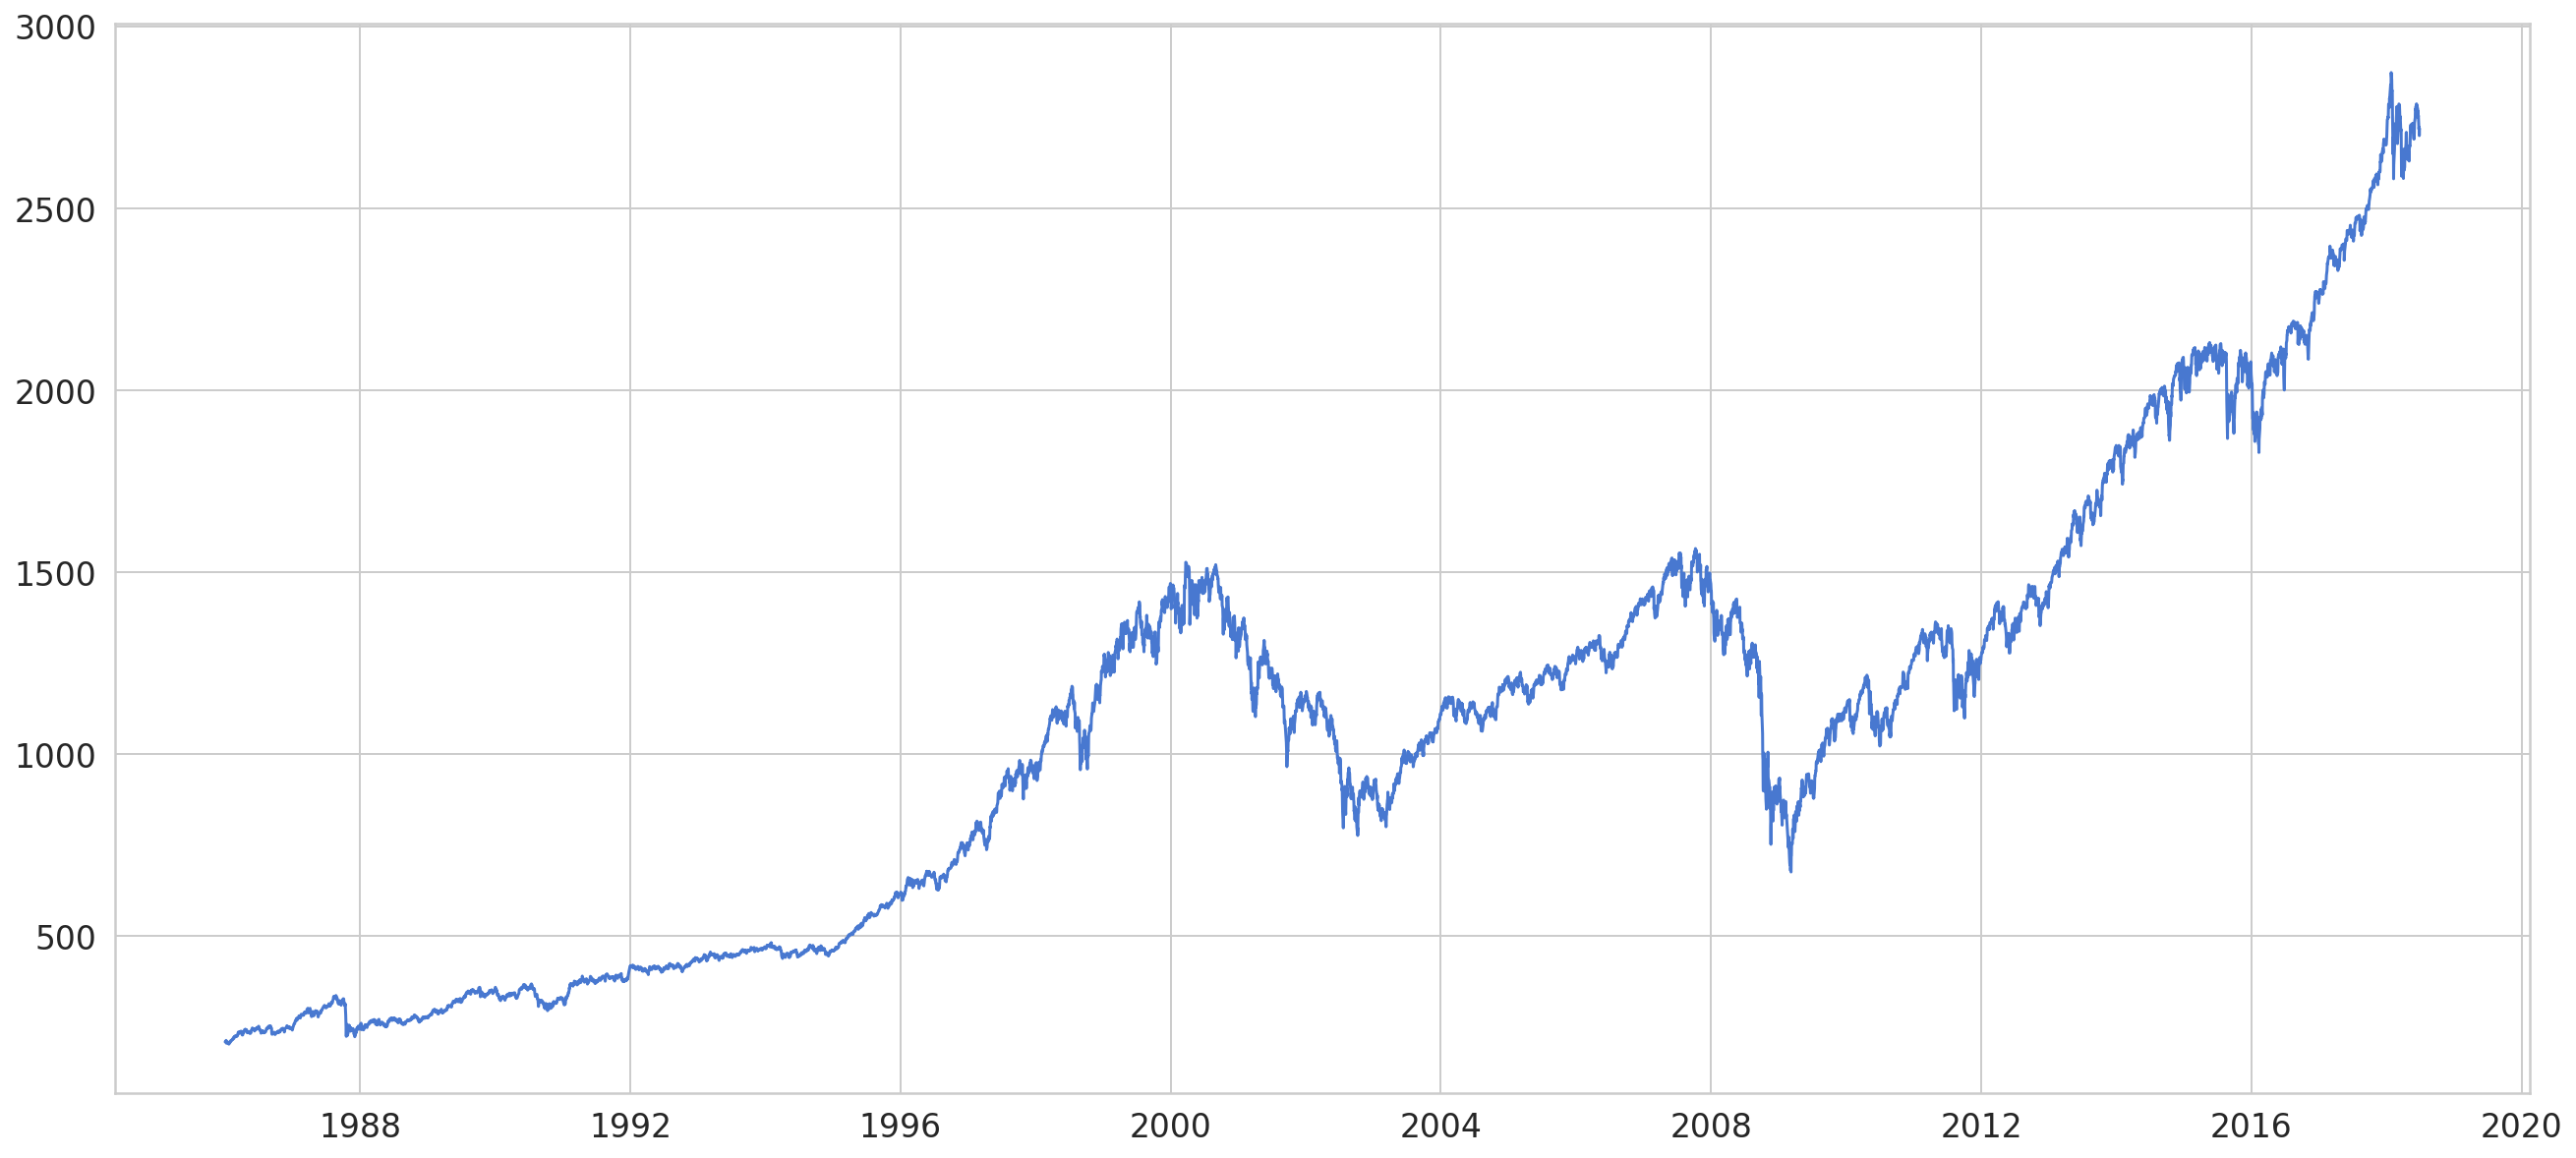

In [0]:
plt.plot(df, label='close price')

In [0]:
train_size=int(len(df) * .95) 
test_size= len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
train.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

   

In [0]:
 TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['close']],train.close,TIME_STEPS)
X_test, y_test = create_dataset(test[['close']],test.close,TIME_STEPS)
print(X_train.shape)


(7752, 30, 1)


In [0]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [0]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1691 - val_loss: 0.1823
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.0935 - val_loss: 0.1604
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.0965 - val_loss: 0.1284
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.0880 - val_loss: 0.1054
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.0918 - val_loss: 0.0654
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.1043 - val_loss: 0.0969
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.1005 - val_loss: 0.0769
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.1094 - val_loss: 0.0630
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.1030 - val_loss: 0.1192
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.1133 - val_loss: 0.0865

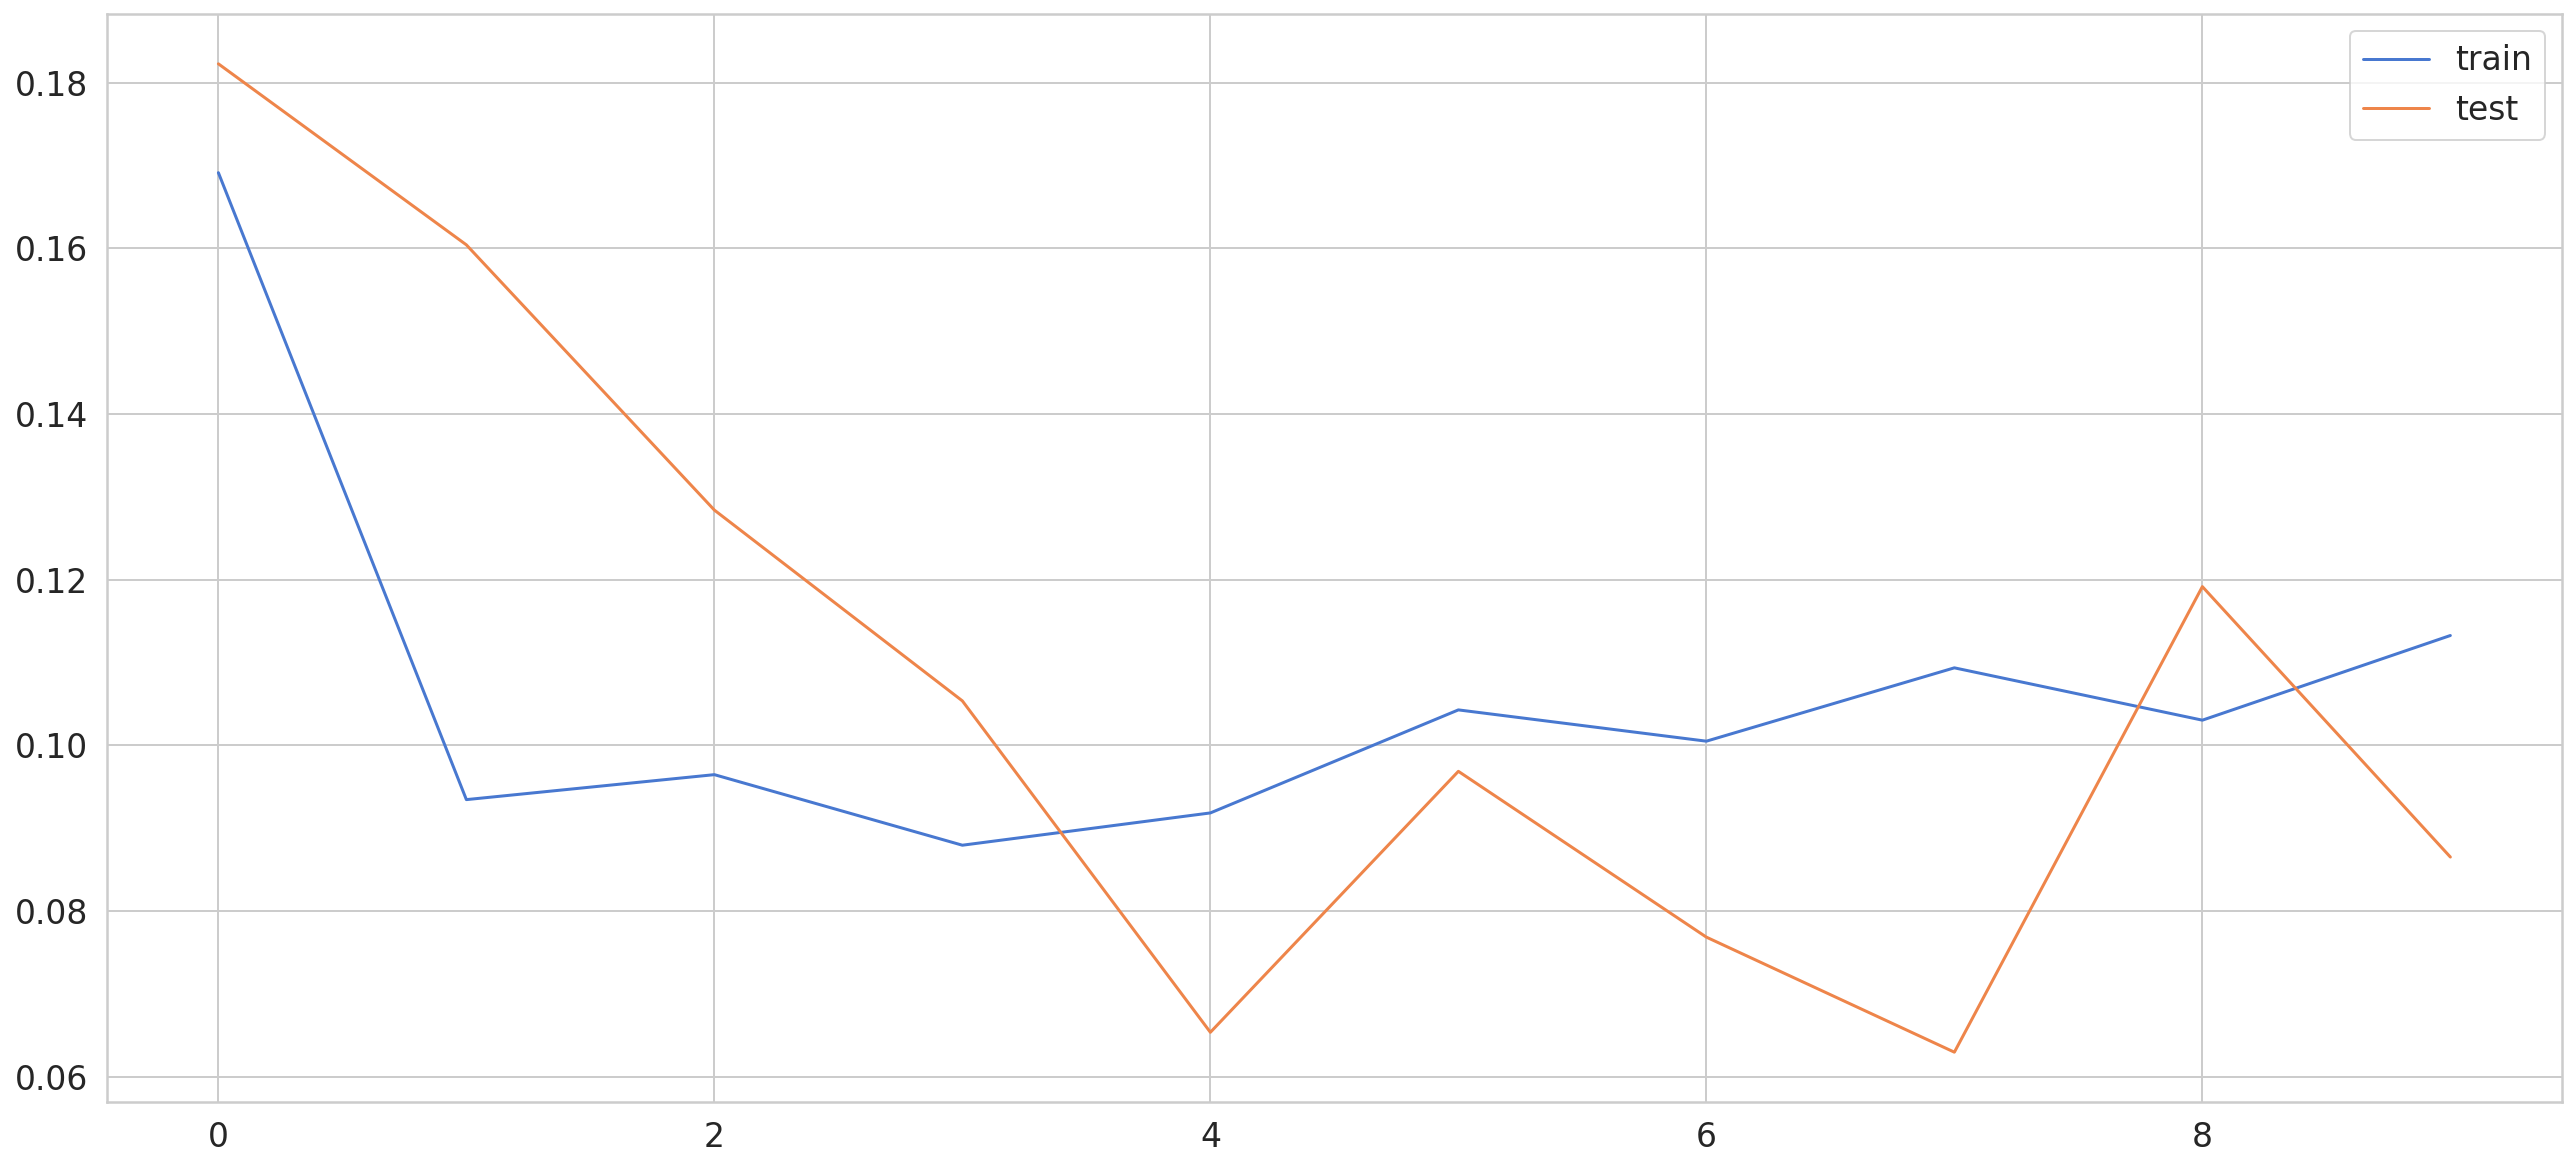

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

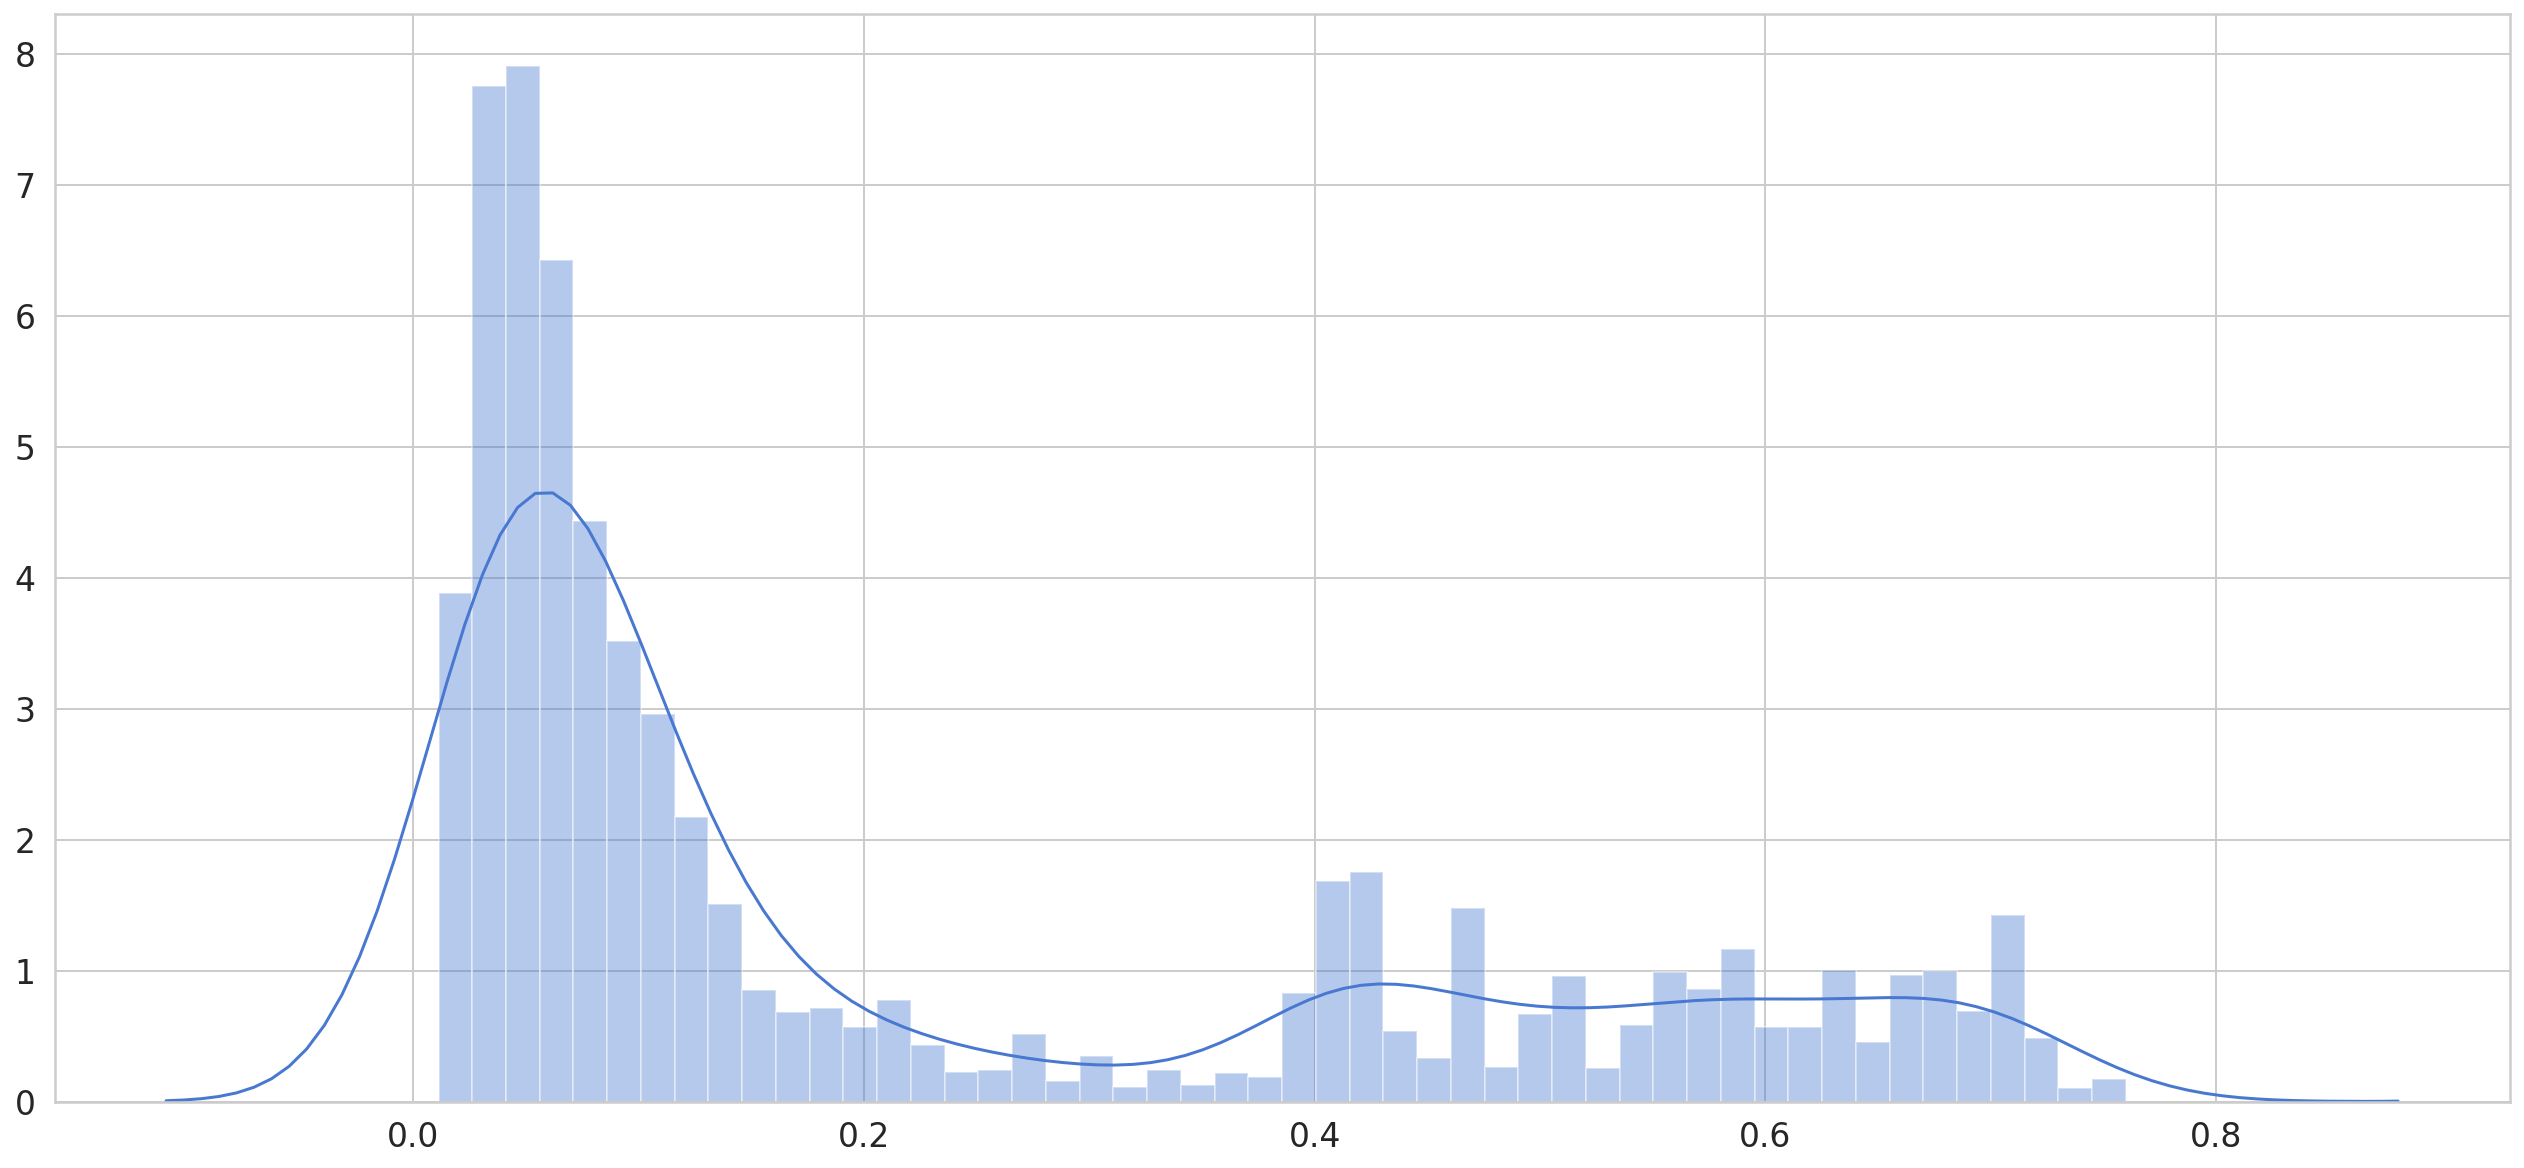

In [0]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
THRESHOLD = 0.5

In [0]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [0]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

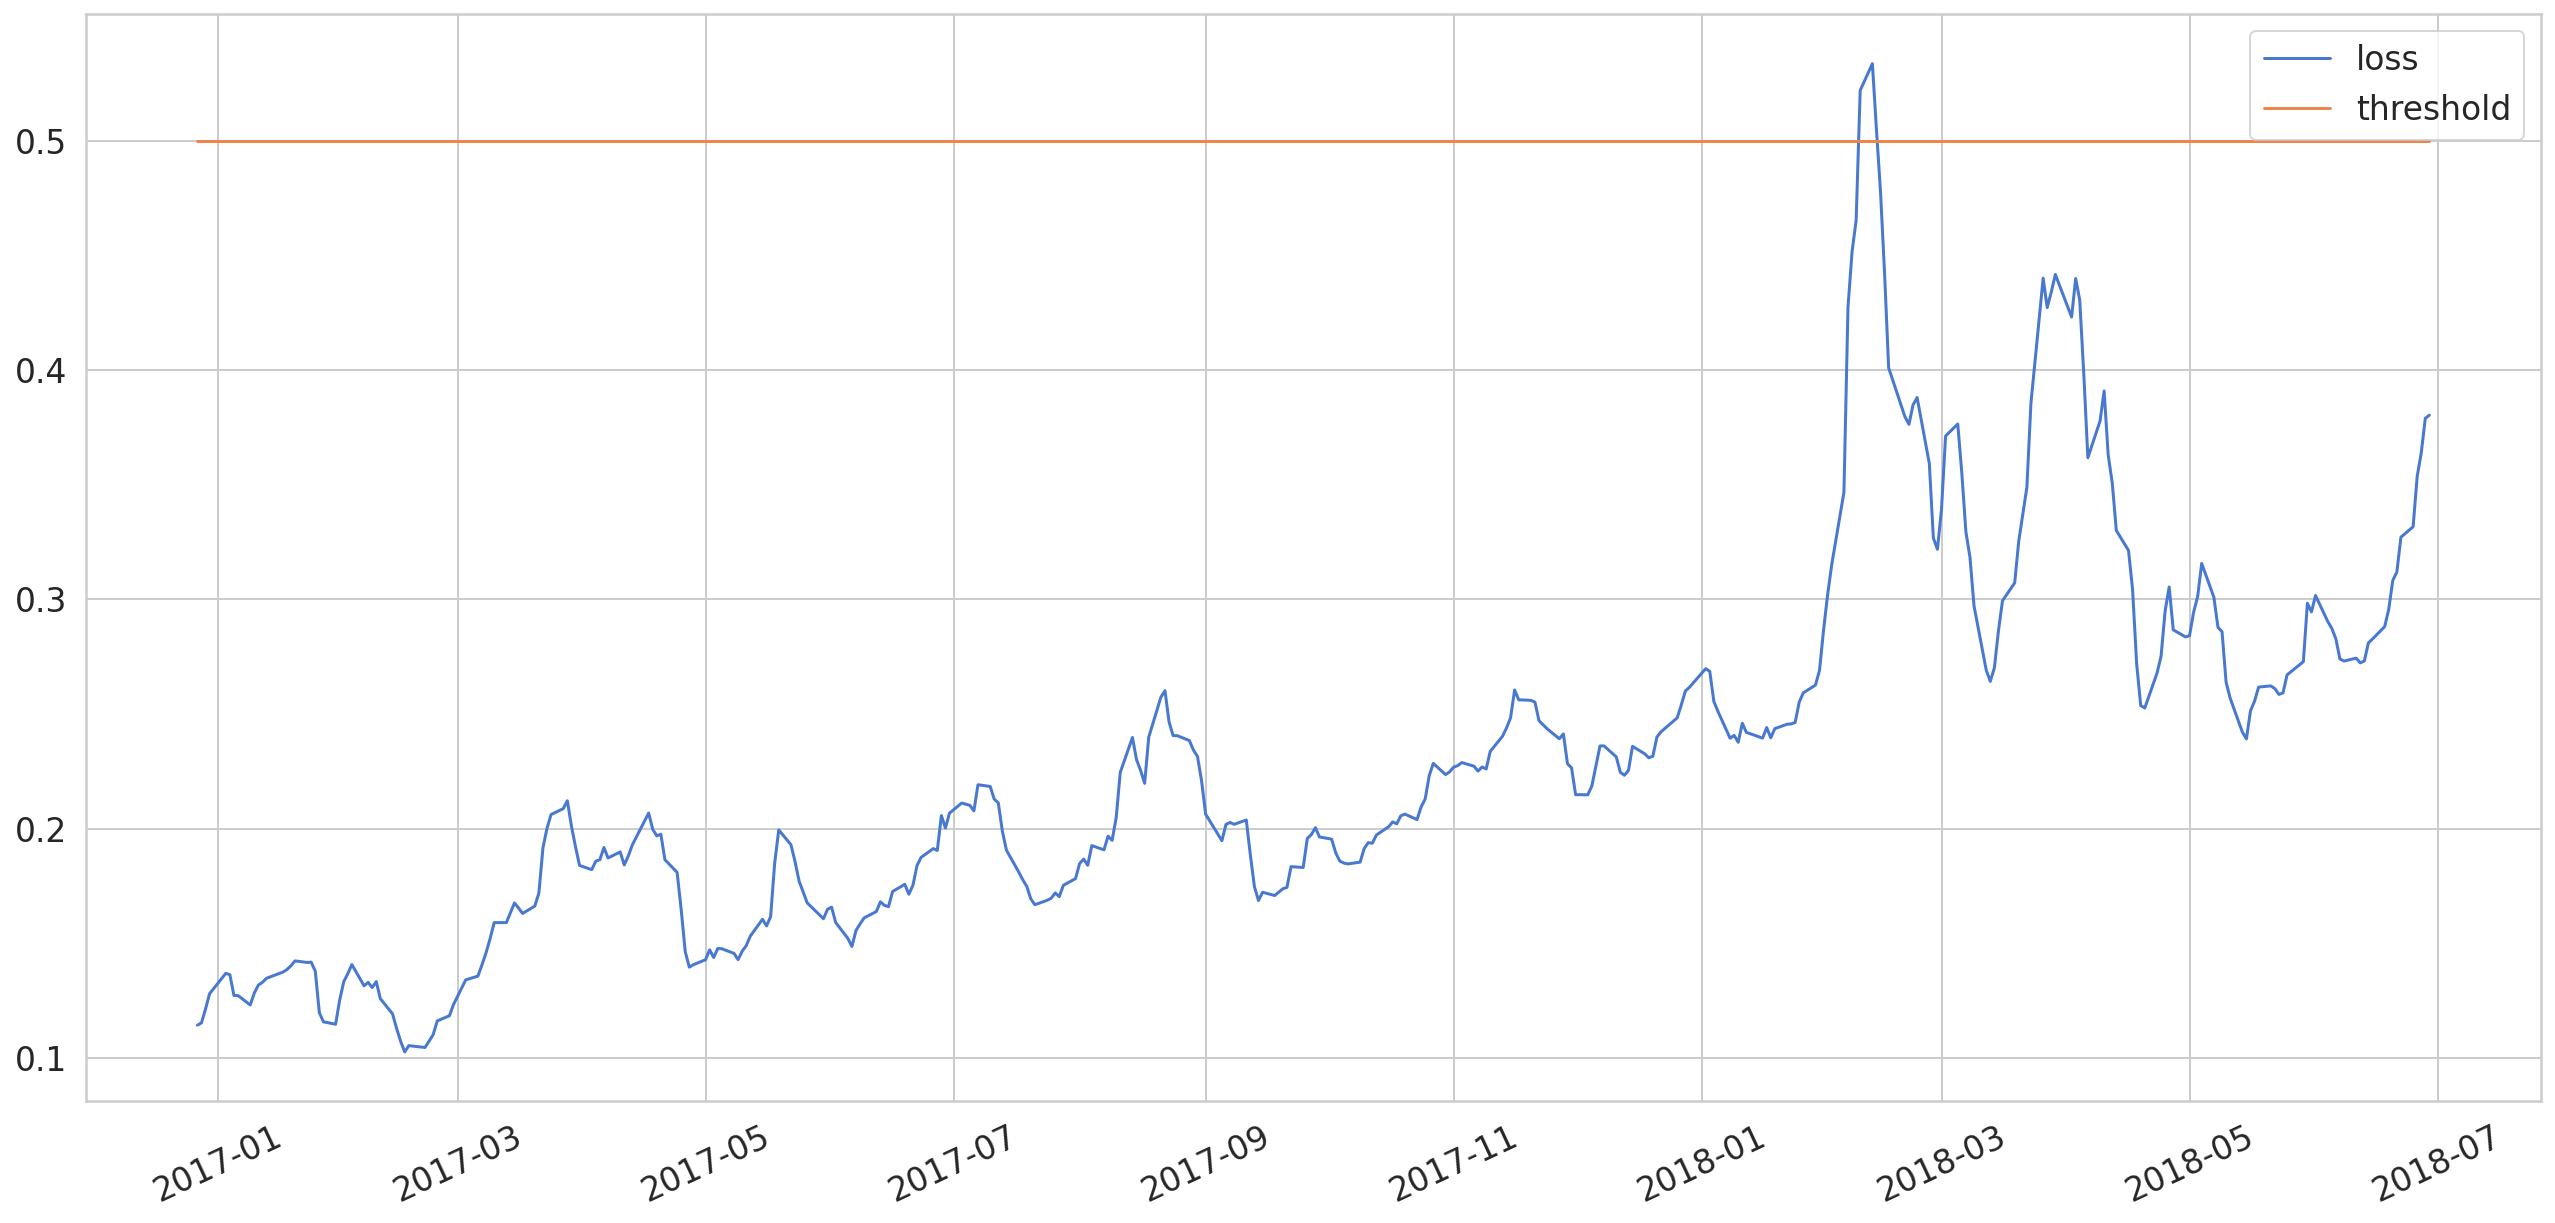

In [0]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();


In [0]:
anomalies = test_score_df[test_score_df.anomaly == True]

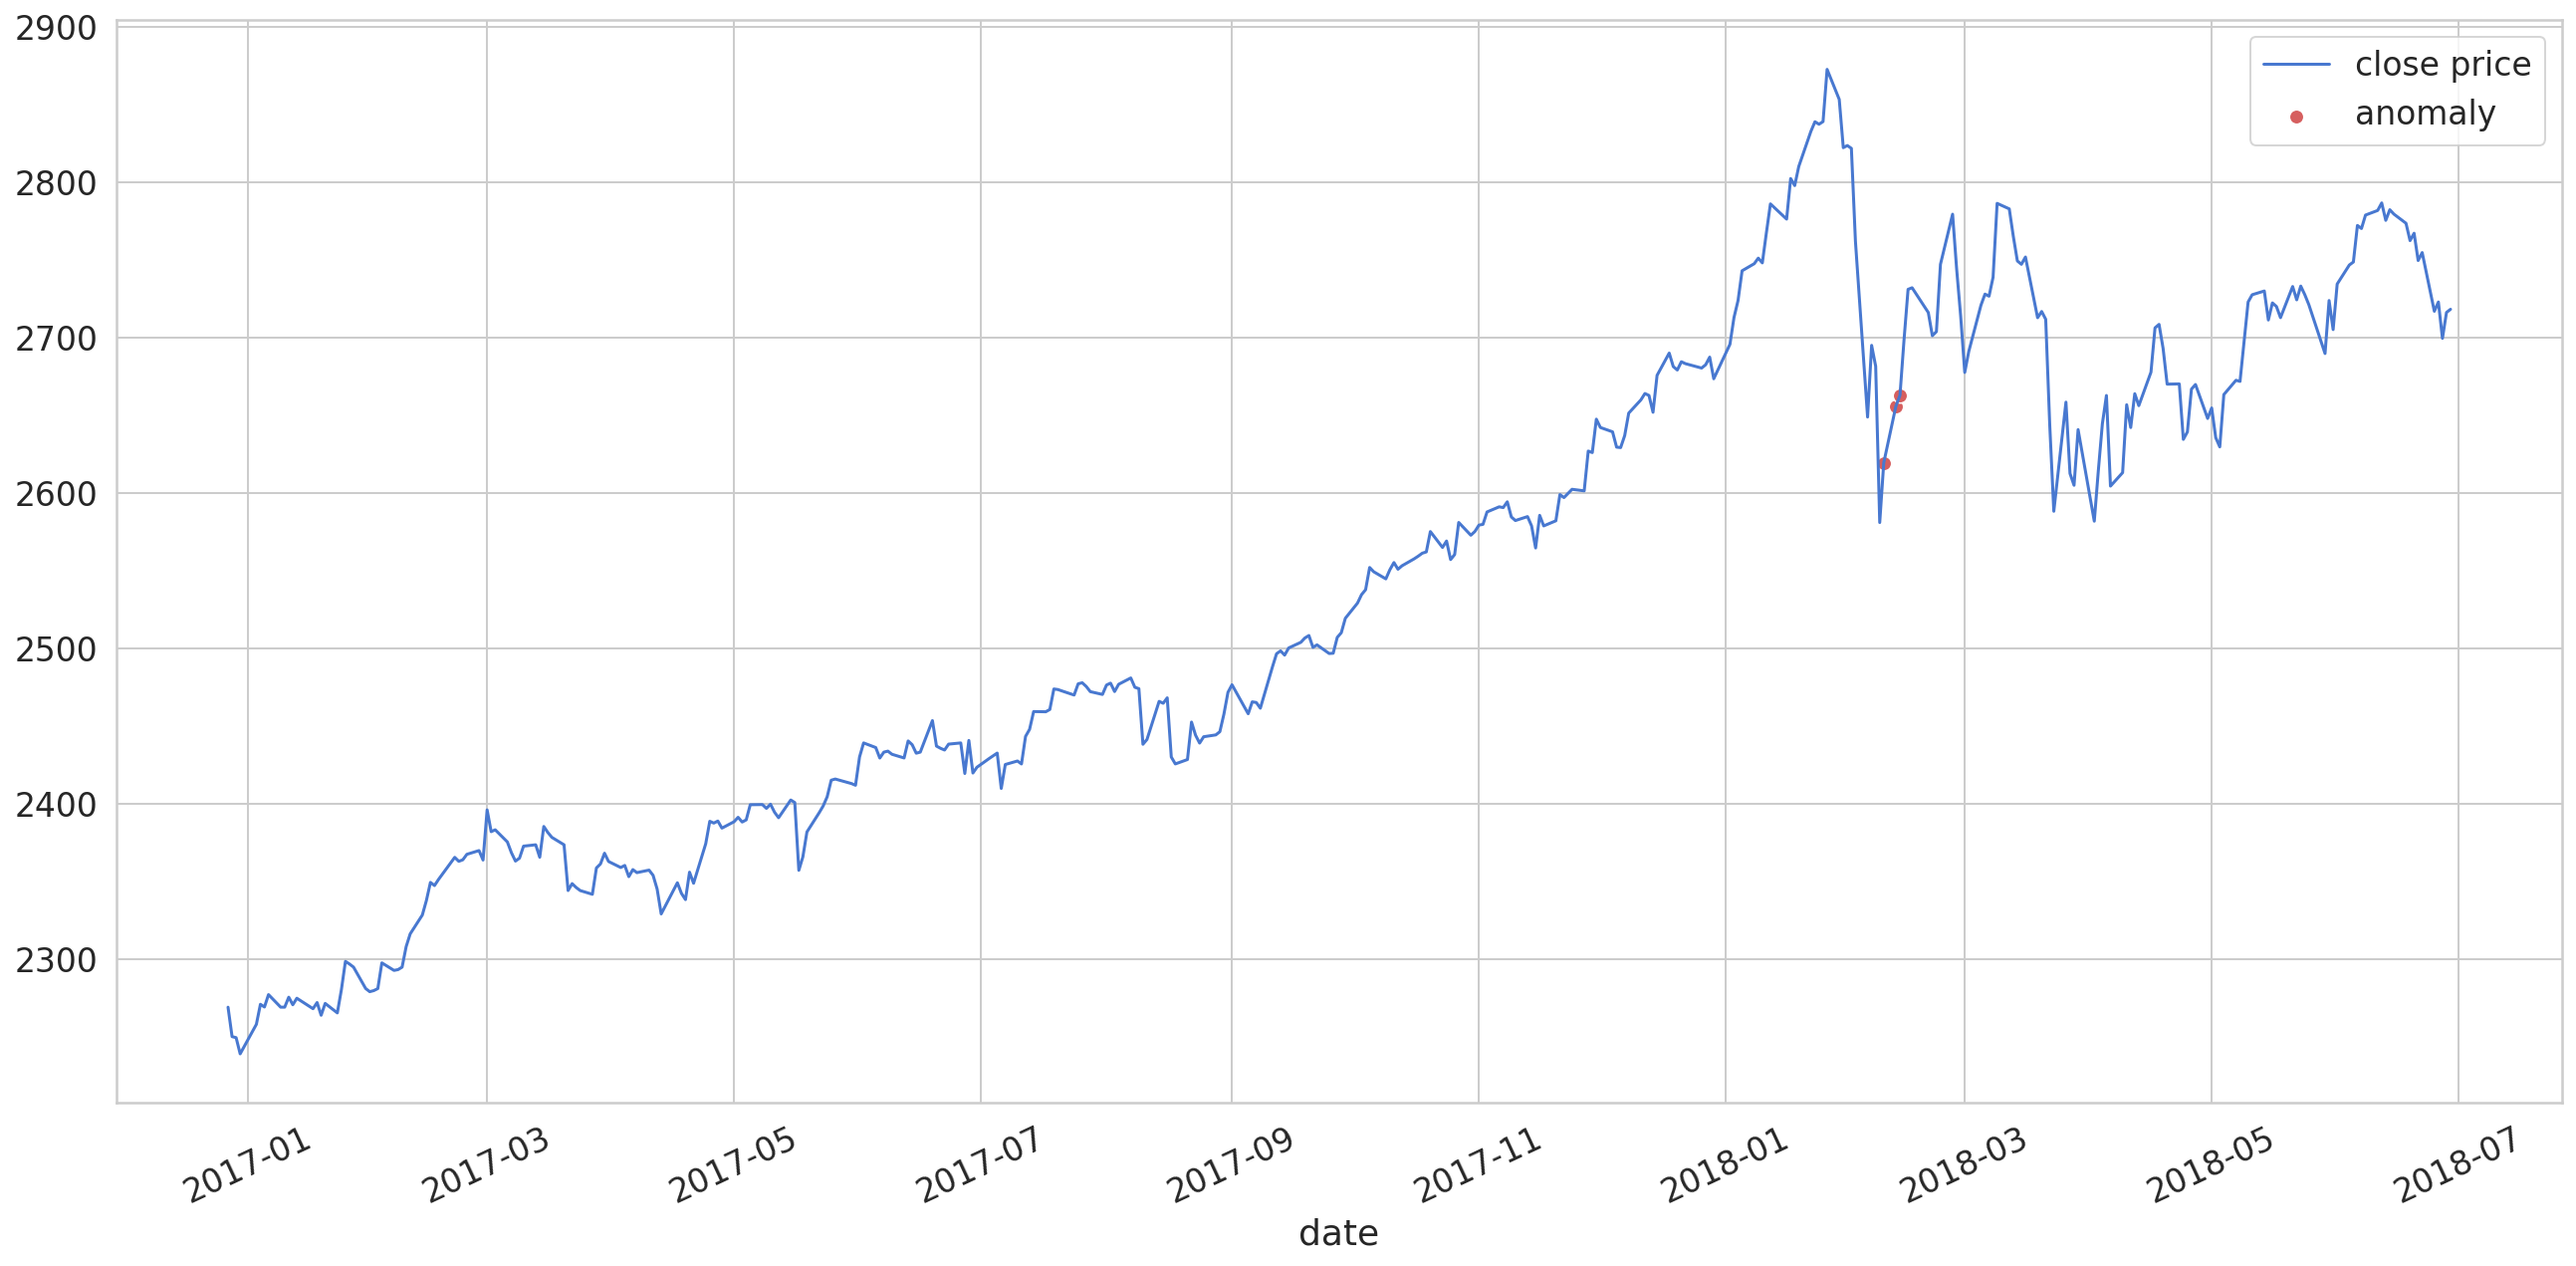

In [0]:
plt.plot(test[TIME_STEPS:].index,scaler.inverse_transform(test[TIME_STEPS:].close),label='close price');

sns.scatterplot(anomalies.index, scaler.inverse_transform(anomalies.close),color=sns.color_palette()[3], s=52,label='anomaly')

plt.xticks(rotation=25)
plt.legend();
 